**Load in Inverse Phi model**

In [2]:
%pylab inline 
inv_phi_dat = np.load('/mnt/store1/oliverphilcox/PowerSpectra/InvPhiMultipoles.npz')
r_cen = inv_phi_dat.f.r
multipoles=inv_phi_dat.f.multipoles

Populating the interactive namespace from numpy and matplotlib


### Fit these to smooth splines;

In [3]:
from scipy.interpolate import UnivariateSpline
class inv_phi():
    def __init__(self,ell):
        self.ell=ell
        self.full_dat = multipoles[ell//2]
        #if self.ell>4:
        #    self.full_dat*=0.
        self.spl = UnivariateSpline(r_cen,self.full_dat,s=5)
    def spline(self,r):
        return self.spl(r)
def which_phi(ell):
    if ell in [0,2,4,6,8]:
        return inv_phi(ell)
    else:
        raise Exception("This ell not implemented")

In [4]:
from scipy.special import legendre
mu_all = np.linspace(0.,1.,200)
r_all = np.linspace(0.,200.,200)
inv_phi_mat = np.zeros([len(r_all),len(mu_all)])
for j in range(len(mu_all)):
    for ell in [0,2,4,6,8]:
        inv_phi_mat[:,j]+=legendre(ell)(mu_all[j])*which_phi(ell).spline(r_all)

Text(0.5,0,'$r$')

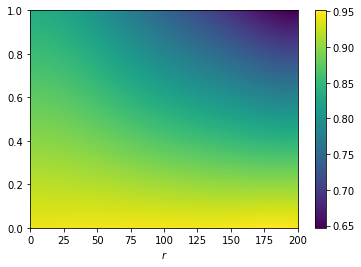

In [5]:
rr,mumu = np.meshgrid(r_all,mu_all)
plt.pcolor(rr,mumu,inv_phi_mat);plt.colorbar();
plt.xlabel(r'$r$')

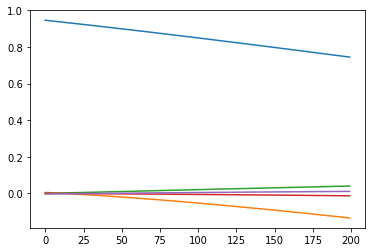

In [6]:
r_all = np.arange(0,200,1)
plt.plot(r_all,which_phi(0).spline(r_all))
plt.plot(r_all,which_phi(2).spline(r_all))
plt.plot(r_all,which_phi(4).spline(r_all))
plt.plot(r_all,which_phi(6).spline(r_all))
plt.plot(r_all,which_phi(8).spline(r_all))

**Compute Window Function**

In [7]:
def windower(r,R_cut,R_max):
    b = R_cut/R_max
    a = (R_max-R_cut)/(2.*R_max)
    x = r/R_max
    if type(r)==float or type(r)==np.float64:
        if x<b:
            return 1.
        elif x<b+a:
            return 1.-((x-b)/a)**3.+0.5*((x-b)/a)**4.
        elif x<1:
            return -((x-b-2*a)/a)**3.-0.5*((x-b-2*a)/a)**4.
        else:
            return 0.
    else:
        output = np.zeros_like(r)
        x = r/R_max
        filt1 = np.where(x<b)
        filt2 = np.where((x>b)&(x<b+a))
        filt3 = np.where((x>b+a)&(x<1))
        output[filt1] = 1.
        output[filt2] = 1.-((x[filt2]-b)/a)**3.+0.5*((x[filt2]-b)/a)**4.
        output[filt3] = -1.*((x[filt3]-b-2*a)/a)**3.-0.5*((x[filt3]-b-2*a)/a)**4.
        return output

**Load Correlation Function Model**

In [8]:
xi_file = np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_xi.npz')
xi_r = xi_file['r']
xi_ell = np.asarray([xi_file['r2xi0'],xi_file['r2xi2'],xi_file['r2xi4']]).T

In [9]:
from scipy.interpolate import UnivariateSpline
class xi_spline():
    def __init__(self,ell):
        self.ell=ell
        if ell in [0,2,4]:
            l_i=ell//2
            self.xi_ell_all = xi_ell[:,l_i]
            self.xi_fit = UnivariateSpline(xi_r,self.xi_ell_all,s=10)
    def r2xi_spline(self,r):
        if self.ell in [0,2,4]:
            return self.xi_fit(r)
        else:
            return r*0.

In [10]:
spl0=xi_spline(0)
spl2=xi_spline(2)
spl4=xi_spline(4)
spl6=xi_spline(6)
spl8=xi_spline(8)

def all_spl(ell):
    if ell==0:
        return spl0
    elif ell==2:
        return spl2
    elif ell==4:
        return spl4
    elif ell==6:
        return spl6
    elif ell==8:
        return spl8
    else:
        return 0.

In [11]:
from sympy.physics.wigner import wigner_3j
from scipy.integrate import quad
from scipy.special import spherical_jn
def aniso_pow(k_all,ell,R0):
    out=np.zeros_like(k_all)
    for l1 in [0,2,4,6,8]:
        for l2 in [0,2,4,6,8]:
            this_phi = which_phi(l2)
            wig = wigner_3j(ell,l1,l2,0,0,0)
            if wig!=0:
                k_int = lambda kk: quad(lambda r: spherical_jn(ell,kk*r)*all_spl(l1).r2xi_spline(r)*windower(r,R0/2,R0)*this_phi.spline(r),0,R0,epsrel=1e-4)
                tmp_int = np.asarray([k_int(kk)[0] for kk in k_all])
                out+=tmp_int*float(wig.n())
    return out*4.*np.pi*(-1.)**(ell/2.)*(2.*ell+1.)

In [317]:
def uncorr_pow(k_all,ell,R0):
    k_int = lambda kk: quad(lambda r: spherical_jn(ell,kk*r)*all_spl(ell).r2xi_spline(r)*windower(r,R0/2,R0),0,R0,epsrel=1e-4)
    tmp_int = np.asarray([k_int(kk)[0] for kk in k_all])
    return tmp_int*4.*np.pi*(-1.)**(ell/2.)

In [318]:
all_pow=[];
all_true=[]
for ell in [0,2,4]:
    k_all = np.linspace(0.05,1.,100)
    pows=aniso_pow(k_all,ell,200)
    true=uncorr_pow(k_all,ell,200)
    all_pow.append(pows)
    all_true.append(true)

(0.0, 1.0)

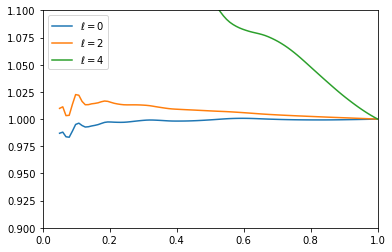

In [319]:
for i in range(3):
    plt.plot(k_all,all_pow[i]/all_true[i]/all_pow[i][-1]*all_true[i][-1],label=r'$\ell=%d$'%(2*i))
plt.legend();
plt.ylim([0.9,1.1])
plt.xlim([0.,1.])

In [320]:
np.savez('/mnt/store1/oliverphilcox/PowerSpectra/window_plot_effects',k=k_all,corr=all_pow,uncorr=all_true,ells=[0,2,4])